In [124]:
import os

from PIL import Image
import dotenv
import torchvision.transforms as T
import albumentations as A
import numpy as np
import cv2

dotenv.load_dotenv(override=True)

TEMP = os.getenv("TEMP")
if not TEMP:
    raise Exception('Not able to find environment variable')

BTSD = os.getenv("BTSD")
if not BTSD:
    raise Exception('Not able to find environment variable')

In [11]:
temp_files = sorted(os.listdir(TEMP))
len(temp_files)

53

In [12]:
btsd_files = sorted(os.listdir(BTSD))
len(btsd_files)

3463

In [185]:
def brightness(img, alpha=None, beta=None):
    if alpha is None:
        alpha = np.random.uniform(0.75, 1.25)
    if beta is None:
        beta = np.random.uniform(-120, 120)

    adjusted_image = alpha * (img.astype(np.float32) + beta)
    return np.clip(adjusted_image, a_min=0, a_max=255).astype(np.uint8), alpha, beta

def get_mask(img):
    mask = np.zeros(img[:,:,:3].shape, np.uint8)
    mask[img[:, :, 3] > 0] = 255
    return mask

In [203]:
img = cv2.imread(os.path.join(BTSD, btsd_files[100]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img, alpha, beta = brightness(img)

print(img.shape, img.dtype, alpha, beta)

(1236, 1628, 3) uint8 0.9991272716335067 -55.53107848315574


(194, 194, 3) uint8 (194, 194, 3) 194


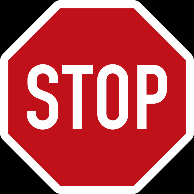

In [204]:
# load
tmp = cv2.imread(os.path.join(TEMP, temp_files[5]), cv2.IMREAD_UNCHANGED)

mask = get_mask(tmp)
tmp = cv2.cvtColor(tmp[:,:,:3], cv2.COLOR_BGR2RGB)

# resize
max_size = int(np.random.choice(range(30,200)))
tmp = A.LongestMaxSize(max_size=max_size)(image=tmp)['image']
mask = A.LongestMaxSize(max_size=max_size)(image=mask)['image']

# brightness
tmp, _, _ = brightness(tmp, alpha=alpha, beta=0)


print(tmp.shape, tmp.dtype, mask.shape, max_size)

T.ToPILImage()(tmp)

574 1016


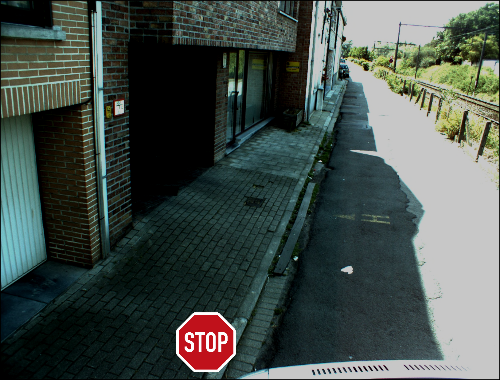

In [205]:
max0 = img.shape[0] - tmp.shape[0]
max1 = img.shape[1] - tmp.shape[1]

pos0 = np.random.choice(range(max0))
pos1 = np.random.choice(range(max1))

print(pos1, pos0)

img[pos0:pos0+tmp.shape[0], pos1:pos1+tmp.shape[1]][mask != 0] = tmp[mask != 0]

img = A.LongestMaxSize(max_size=500)(image=img)['image']
T.ToPILImage()(img)

In [ ]:
tmp

In [33]:
for file in temp_files:
    img = T.ToTensor()(Image.open(os.path.join(TEMP, file)))
    # img = T.Resize(size=(356,365))(img)
    print(img.shape)

torch.Size([4, 350, 530])
torch.Size([4, 350, 530])
torch.Size([4, 899, 1024])
torch.Size([4, 480, 480])
torch.Size([4, 768, 874])
torch.Size([4, 768, 768])
torch.Size([4, 240, 240])
torch.Size([4, 800, 800])
torch.Size([4, 240, 240])
torch.Size([4, 768, 874])
torch.Size([4, 899, 1024])
torch.Size([4, 899, 1024])
torch.Size([4, 500, 500])
torch.Size([4, 899, 1024])
torch.Size([4, 899, 1024])
torch.Size([4, 899, 1024])
torch.Size([4, 899, 1024])
torch.Size([4, 480, 547])
torch.Size([4, 899, 1024])
torch.Size([4, 768, 874])
torch.Size([4, 768, 874])
torch.Size([4, 768, 874])
torch.Size([4, 899, 1024])
torch.Size([4, 500, 500])
torch.Size([4, 800, 800])
torch.Size([4, 240, 240])
torch.Size([4, 240, 240])
torch.Size([4, 240, 240])
torch.Size([4, 240, 240])
torch.Size([4, 240, 240])
torch.Size([4, 800, 800])
torch.Size([4, 480, 480])
torch.Size([4, 240, 240])
torch.Size([4, 350, 530])
torch.Size([4, 500, 500])
torch.Size([4, 1024, 1024])
torch.Size([4, 120, 120])
torch.Size([4, 528, 600])
t